In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define parameters
img_width, img_height = 224, 224
batch_size = 32

# Set up data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # for splitting training data into train and validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Update these paths based on your directory structure
base_dir = "/kaggle/input/remotesensing/Remote sensing satellite images dataset for objects detection/rssid"
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Function to read classes from _classes.csv
def read_classes(directory):
    classes_file = os.path.join(directory, '_classes.csv')
    if os.path.exists(classes_file):
        return pd.read_csv(classes_file)
    return pd.DataFrame()

# Read classes for each set
train_df = read_classes(train_dir)
valid_df = read_classes(valid_dir)
test_df = read_classes(test_dir)

# Get all unique classes
classes = [' residence', ' roads', ' shoreline', ' swimming pool', ' vegetation']

# Function to create labels
def create_labels(row):
    return [row[class_name] for class_name in classes]

# Add labels column to dataframes
train_df['labels'] = train_df.apply(create_labels, axis=1)
valid_df['labels'] = valid_df.apply(create_labels, axis=1)
test_df['labels'] = test_df.apply(create_labels, axis=1)

# Print some information
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Classes: {classes}")

Train set size: 61
Validation set size: 21
Test set size: 10
Classes: [' residence', ' roads', ' shoreline', ' swimming pool', ' vegetation']


In [10]:
# Custom generator
def multi_label_flow_from_dataframe(dataframe, directory, x_col, y_col, generator, **kwargs):
    gen = generator.flow_from_dataframe(
        dataframe,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        class_mode='raw',
        **kwargs
    )
    while True:
        x, y = next(gen)
        y = np.array([np.array(label) for label in y], dtype=np.float32)
        yield x, y

# Create generators
train_generator = multi_label_flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="filename",
    y_col="labels",
    generator=datagen,
    subset="training",
    target_size=(img_width, img_height),
    batch_size=batch_size
)

validation_generator = multi_label_flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="filename",
    y_col="labels",
    generator=datagen,
    subset="validation",
    target_size=(img_width, img_height),
    batch_size=batch_size
)

test_generator = multi_label_flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col="filename",
    y_col="labels",
    generator=test_datagen,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False
)

# Verify generators
x, y = next(train_generator)
print("Sample batch shape:", x.shape)
print("Sample labels shape:", y.shape)
print("Input dtype:", x.dtype)
print("Labels dtype:", y.dtype)

# Print a few sample labels to verify
print("Sample labels (first 5 images):")
for i in range(5):
    print(f"Image {i+1}: {y[i]}")

Found 49 validated image filenames.
Sample batch shape: (32, 224, 224, 3)
Sample labels shape: (32, 5)
Input dtype: float32
Labels dtype: float32
Sample labels (first 5 images):
Image 1: [1. 1. 0. 1. 1.]
Image 2: [1. 1. 0. 1. 1.]
Image 3: [1. 1. 0. 1. 1.]
Image 4: [1. 1. 0. 1. 1.]
Image 5: [1. 1. 0. 1. 1.]


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Set up model parameters
input_shape = (img_width, img_height, 3)
num_classes = len(classes)

# Create and compile the model
model = create_model(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,805 (237.52 KB)

 Trainable params: 60,805 (237.52 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Set up callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

# Train the model
epochs = 20  # Increased epochs, but we'll likely stop early
steps_per_epoch = max(1, len(train_df) // batch_size)
validation_steps = max(1, len(valid_df) // batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0588 - loss: 0.6998Found 12 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0588 - loss: 0.6998 - val_accuracy: 0.0000e+00 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1250 - loss: 0.6923 - val_accuracy: 0.0000e+00 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4706 - loss: 0.6800 - val_accuracy: 0.0000e+00 - val_loss: 0.6514 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4062 - loss: 0.6589 - val_accuracy: 1.0000 - val_loss: 0.6287 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2353 - loss: 0.6245 - val_accuracy: 1.0000 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.6117 - val_accuracy: 0.3333 - val_loss: 0.5720 - learning_rate: 0.0010
E

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
test_steps = len(test_df) // batch_size + 1

# Predict on test data
y_pred = model.predict(test_generator, steps=test_steps)

# Get true labels
test_generator_for_labels = multi_label_flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col="filename",
    y_col="labels",
    generator=test_datagen,
    target_size=(img_width, img_height),
    batch_size=len(test_df),
    shuffle=False
)
_, y_true = next(test_generator_for_labels)

# Ensure y_pred and y_true have the same number of samples
y_pred = y_pred[:len(y_true)]

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary, average='micro')
recall = recall_score(y_true, y_pred_binary, average='micro')
f1 = f1_score(y_true, y_pred_binary, average='micro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Found 10 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Found 10 validated image filenames.
Accuracy: 0.5000
Precision: 0.8750
Recall: 0.9459
F1-score: 0.9091


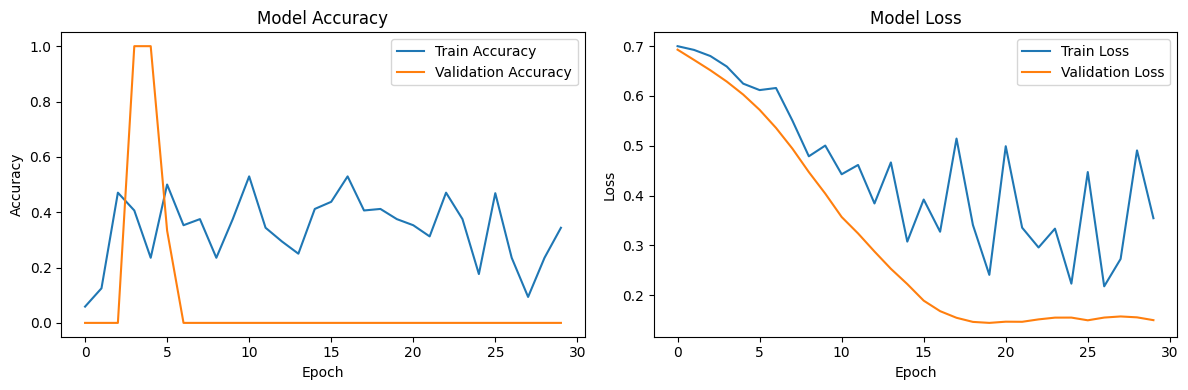

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Print per-class metrics
for i, class_name in enumerate(classes):
    class_precision = precision_score(y_true[:, i], y_pred_binary[:, i])
    class_recall = recall_score(y_true[:, i], y_pred_binary[:, i])
    class_f1 = f1_score(y_true[:, i], y_pred_binary[:, i])
    print(f"\nMetrics for {class_name}:")
    print(f"Precision: {class_precision:.4f}")
    print(f"Recall: {class_recall:.4f}")
    print(f"F1-score: {class_f1:.4f}")


Metrics for  residence:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Metrics for  roads:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Metrics for  shoreline:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Metrics for  swimming pool:
Precision: 0.6000
Recall: 1.0000
F1-score: 0.7500

Metrics for  vegetation:
Precision: 0.9000
Recall: 1.0000
F1-score: 0.9474


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
